# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [64]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

In PCA, we're finding basis vectors that best explains the variance of the data. Whereas in ICA, we're finding basis vectors that are statistically independent of the projected data. Given that this is a daily grocery distributor, it seems very likely that the first PCA dimension be an eigenvector that best describes the variance and is something that has a market that sustains daily delivery, such as *milk* or *fresh produce*. For ICA, since all features will be used, a 6x6 matrix will likely be returned - six vectors comprised of the six features.

###PCA

In [84]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6).fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pd.DataFrame(pca.components_, columns=list(data.columns))
print '\n'
print pca.explained_variance_ratio_

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0 -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
1 -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079
2 -0.178557  0.509887 -0.275781  0.714200         -0.204410      0.283217
3 -0.041876 -0.645640  0.375460  0.646292          0.149380     -0.020396
4  0.015986  0.203236 -0.160292  0.220186          0.207930     -0.917077
5 -0.015763  0.033492  0.410939 -0.013289         -0.871284     -0.265417


[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


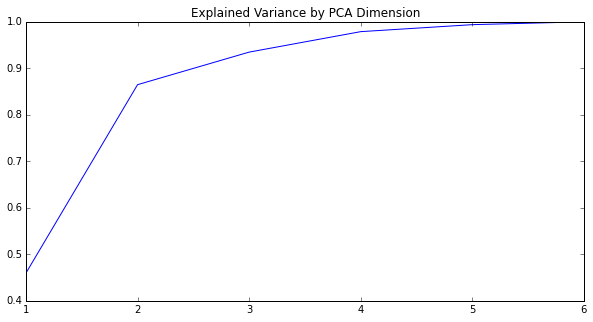

In [81]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,7), np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance by PCA Dimension')

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

As seen in the above plot, the variance drops sharply after the second component and much more gradually after that. The goal of PCA is to minimize information loss and keep as much of the original information as possible by retaining the maximum variance in the data. From analyzing the graph, we can make a simple and intuitive call that the first two principal components retains majority of the variance - about 86% of the variance.

**3)** What do the dimensions seem to represent? How can you use this information?

The first component appears to incorporate mostly `Fresh` and a little of `Frozen` and `Milk`. The second component is comprised of `Grocery`, `Milk`, and `Detergents_Paper`.

The dimensions represent eigenvectors, and the directions, along the data that has variation. In this case, the first two components have the majority of the variance and that is where there is the most information. Therefore, instead of representing the data in six dimensions, we can get rid of the directions with little information and only represent the data in two dimensions as described by the eigenvectors.

###ICA

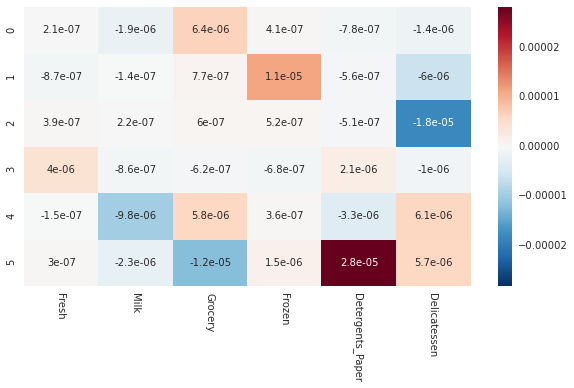

In [159]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
import seaborn as sns

centered_data = data.copy()
centered_data -= centered_data.mean()
ica = FastICA(n_components=6).fit(centered_data)

# Print the independent components
ica_data = pd.DataFrame(ica.components_, columns=list(data.columns))

plt.figure(figsize=(10,5))
plt.xticks(rotation=270)
sns.heatmap(ica_data, annot=True)

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

The goal of ICA is to find a basis along which the data, when projected, is statistically independent. Looking at the first component in the ICA analysis, it appears to be mainly comprised of `Grocery`, `Delicatessen` and `Milk`. The second basis vector incorporates mostly `Frozen` and `Delicatessen`. The third appears to be predominantly `Delicatessen`. The fourth component is mostly comprised of `Fresh` and `Detergents_Paper`. The last two basis vectors are very variable where they are incorporating `Milk`, `Grocery`, `Detergents_Paper` and `Delicatessen`.

These componenets can be used to trim down the feature set into new ones that are statistically independent from one another. Thus making the decision boundaries all the more apparent for clustering or classification.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Advantages of K Means clustering:
- With a large number of variables, K-Means may be computationally faster than hierarchical clustering (if K is small).
- K-Means may produce tighter clusters than hierarchical clustering, especially if the clusters are globular.

Advantages of Gaussian Mixture Models:
- It is the fastest algorithm for learning mixture models
- The GMM algorithm is a good algorithm to use for the classification of static postures and non-temporal pattern recognition.


**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [28]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [160]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = PCA(n_components=2).fit_transform(centered_data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [161]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

clusters = GMM(n_components=2).fit(reduced_data)
# clusters = GMM(n_components=3).fit(reduced_data)
# clusters = KMeans(n_clusters=2).fit(reduced_data)
# clusters = KMeans(n_clusters=3).fit(reduced_data)
print clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)


In [162]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [163]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.means_
# centroids = clusters.cluster_centers_
print centroids

[[-10810.23008886   9858.15532401]
 [  3308.39301792  -3017.01739698]]


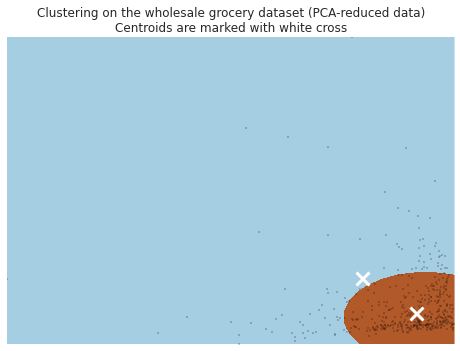

In [164]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

There are two distint clusters: highest volume customers, and smaller family run shops. The central objects are denoted by the white `X` mark that represents the average customer in each cluster. Upon further inspection, we can conclude that the smaller family run shops have low variation between themselves and are grouped closely together at the bottom right. Whereas the high volume customers have high variations are represent the rest of the space.

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

The most insightful technique was Principal Component Analysis (PCA) coupled with Gaussian Mixture Model (GMM). While the dataset was fairly small with only six features, PCA was still helpful in determining the components with the highest variances; PCA is even more effective on large datasets with lots of features. PCA enabled dimensionality reduction to assist with clustering. For grouping the dataset together, either K Means or GMM would have been suitable. But GMM was preferred as it incorporated expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models, which is helpful when a clear divide is not present. Grouping the data into clusters using GMM enables us to bucket the customers into their respective market segments and thus facilitates better business decision making.

**9)** How would you use that technique to help the company design new experiments?

Now that we have defined two groups of customers, we can use this to design better A/B tests. For example, if the company were to retest the change to their delivery method, from a regular morning delivery to a cheaper, bulk evening delivery, they would respectively run this experiment on the two defined customer segments. It is very likely that they would have observed little to no change in high volume customers, but a statistically significant decline in satisfaction or increase in churn in the smaller family run shop segment. This would have helped the company adapt different delivery methods to their different customer segments.

The company can use this technique to find segments of customers that purchase a certain kind of product, say frozen foods. They can then craft various marketing initiatives, such as a wholesale discount, to A/B test on the different segments and observe the impact. If a particular change shows promise, they can be implement to select segments thereby creating and catering to their market niches.

**10)** How would you use that data to help you predict future customer needs?

Now that we have defined the customer segments, the company can run segmentation analysis to evaluate the sales, profitability, and growth of each group. Say if, high volume customers had higher sales and profit figures along with growth potential, the company could stategically choose to focus their efforts on this segment while ignoring the rest in an effort to streamline the business. 

On the other hand, the business could choose to tailor their product offering to their two customer segments. They can then make use of supervised machine learning techniques to model buying habits of each group to ensure necessary inventory and delivery, or predict the likelyhood of a customer churning. All these predictions allows the company to be proactive in it's approach to better serve it's customers.

###References

- [Principal Component Analysis 4 Dummies: Eigenvectors, Eigenvalues and Dimension Reduction](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/)
- [Interpretation of the Principal Components](https://onlinecourses.science.psu.edu/stat505/node/54)
- [K-Means Clustering Overview](http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/K-Means_Clustering_Overview.htm)
- [Unsupervised Learning](http://www.cs.ccsu.edu/~markov/ccsu_courses/ml-ch10.pdf)
- [Gaussian Mixture Models](https://www.ll.mit.edu/mission/cybersec/publications/publication-files/full_papers/0802_Reynolds_Biometrics-GMM.pdf)